In [1]:
# script_hang indefinitely at points_to_convex_hull_volume_mask

import numpy as np
import stackview
from vedo import Points, ConvexHull, Volume


def points_to_convex_hull_volume_mask(points, volume_shape_zyx, dilation_radius=3) -> Volume:
    """
    Converts a set of 3D points to a binary volume mask of the inner part of the embryo using a convex hull.

    This function takes a set of 3D points and a volume shape, constructs a convex hull from the points,
    binarizes the convex hull into a volume mask, and then erodes/dilates the mask. 

    Args:
        points (numpy.ndarray): A numpy array of shape (N, 3) representing the 3D points in ZYX order.
        volume_shape_zyx (tuple): A tuple (z, y, x) representing the shape of the volume.
        dilation_radius (int): The radius of the dilation applied to the volume mask.  This expands the mask
            outwards, useful for ensuring complete coverage of the structure represented by the points.

    Returns:
        vedo.Volume: A vedo.Volume object representing the binary volume mask.  The mask has values of 255 inside
            the convex hull and 0 outside.
    """
    points_raw = points[:, [2, 1, 0]]
    pts = Points(points_raw)
    print("Creating convex hull from points")
    hull = ConvexHull(pts)

    vol_shape_xyz = volume_shape_zyx[::-1]
    print("Binarizing convex hull into volume mask")
    vol_mask = hull.binarize(values=(255,0),dims=vol_shape_xyz,spacing=[1,1,1], origin=(0,0,0))
    if dilation_radius > 0:
        print(f"Dilating with radius of {dilation_radius}")
        modified = vol_mask.clone().dilate(neighbours=(dilation_radius,dilation_radius,dilation_radius))
    else:
        erosion_radius = abs(dilation_radius)
        print(f"Eroding with erosion radius of {erosion_radius}")
        modified = vol_mask.clone().erode(neighbours=(erosion_radius,erosion_radius,erosion_radius))
    return modified

down_cropped = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/down_cropped_tp_767.npy")
print(down_cropped.shape)
points = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/tp_767_surface_points.npy") 
print(points[0,:,:])
# mod = points_to_convex_hull_volume_mask(points, volume_shape_zyx=down_cropped.shape, dilation_radius=3)

(146, 298, 621)
[ 1 22 46]


In [5]:
stackview.slice(down_cropped, continuous_update=True)

In [6]:
from wbns import substract_background

only_structures = substract_background(down_cropped, 4, 1)

In [7]:
stackview.slice(only_structures, continuous_update=True)

In [9]:
# Otsu is clearly failing hard, and whole image is 1 value

from skimage import filters
from scipy import ndimage as cpu_ndimage


substracted_bkg = only_structures
th = filters.threshold_otsu(substracted_bkg)
mask = substracted_bkg >= th

structuring_element = np.ones((3,3,3))
eroded_mask = cpu_ndimage.binary_erosion(mask, structure=structuring_element).astype(mask.dtype)  # Keep original datatype
# Zerroing out the border to remove artifacts that wbns generates
zero_y = int(eroded_mask.shape[1] * (1.15 - 1) / 2) 
zero_x = int(eroded_mask.shape[2] * (1.15 - 1) / 2)
eroded_mask[:,-zero_y:,:] = False
eroded_mask[:,:zero_y,:] = False
eroded_mask[:,:,-zero_x:] = False
eroded_mask[:,:,:zero_x] = False
stackview.slice(mask, continuous_update=True)

In [16]:
substracted_bkg = only_structures
th = filters.threshold_mean(substracted_bkg)
mask = substracted_bkg >= th
stackview.slice(mask, continuous_update=True)

In [2]:
points.shape

(23110952, 3)

In [17]:
import numpy as np
points_766 = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/tp_766_surface_points.npy")
points_766.shape

(92905, 3)

In [19]:
from scipy.spatial import ConvexHull
import time 

start_time = time.perf_counter()
hull = ConvexHull(points)
end_time = time.perf_counter()

execution_time = end_time - start_time
print(f"Function execution time: {execution_time:.4f} seconds")


Function execution time: 3.1477 seconds


Pruning points in a surface mask

/home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/stackview/_static_view.py:101: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
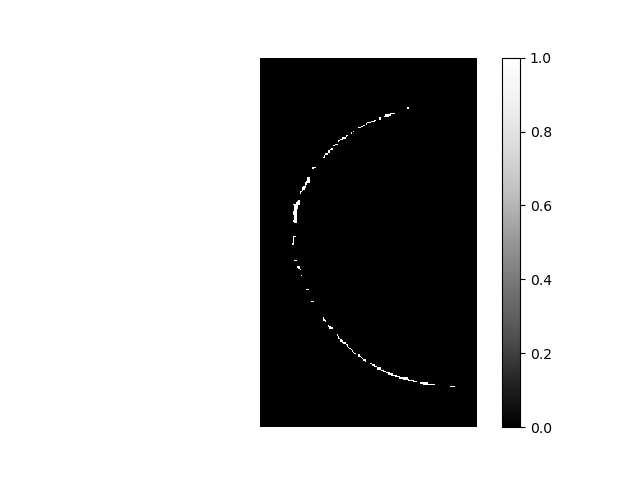
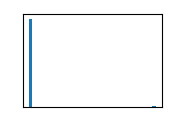

In [38]:
import tifffile as tiff
mask = tiff.imread("outs/tp_301_wbns_surface_voxels_true.tif")
mask = np.transpose(mask, (2,1,0))
stackview.insight(mask[244])

In [140]:
import numpy as np
from numba import njit, prange

@njit(parallel=True, cache=True)
def prune_volume_cpu(volume, block_h=4, block_w=4):
    """
    CPU accelerated pruning of voxels in a 3D volume using Numba.
    
    For each slice in the 3D boolean volume (shape: [n_slices, height, width]), the function:
      - Computes the mid-point of the slice as (x=width//2, y=height//2).
      - Splits the slice into non-overlapping 4x4 blocks by default.
      - Within each block, finds the True pixel furthest from the mid-point (using squared Euclidean distance).
      - Prunes the block by setting all True pixels to False except the selected one.
    
    Parameters:
        volume (np.ndarray): 3D numpy array with boolean values.
        block_h (int): Height of each block.
        block_w (int): Width of each block.
        
    Returns:
        volume (np.ndarray): The modified volume with pruned voxels.
    """
    n_slices, height, width = volume.shape
    block_h, block_w = 4, 4
    # mid-point for each slice (same for all slices)
    mid_y = height // 2
    mid_x = width // 2

    # Compute the number of blocks along each dimension.
    grid_y = (height + block_h - 1) // block_h
    grid_x = (width + block_w - 1) // block_w

    # Process each slice in parallel.
    for s in prange(n_slices):
        for by in range(grid_y):
            for bx in range(grid_x):
                start_y = by * block_h
                start_x = bx * block_w
                max_dist = -1.0
                max_r = -1
                max_c = -1
                # First pass: Find the True pixel with the maximum distance.
                for i in range(block_h):
                    r = start_y + i
                    if r >= height:
                        break
                    for j in range(block_w):
                        c = start_x + j
                        if c >= width:
                            break
                        if volume[s, r, c]:
                            dx = c - mid_x
                            dy = r - mid_y
                            dist = dx * dx + dy * dy
                            if dist > max_dist:
                                max_dist = dist
                                max_r = r
                                max_c = c
                # Second pass: Clear all True pixels except the one with max distance.
                if max_r != -1:  # if at least one True pixel was found
                    for i in range(block_h):
                        r = start_y + i
                        if r >= height:
                            break
                        for j in range(block_w):
                            c = start_x + j
                            if c >= width:
                                break
                            if volume[s, r, c] and not (r == max_r and c == max_c):
                                volume[s, r, c] = False
    return volume

if __name__ == '__main__':
    # Example usage: create a small random volume of shape (2, 8, 8)
    np.random.seed(0)
    volume = (np.random.rand(170, 2900, 635) > 0.9)
    print("Original volume:")
    # print(volume.astype(np.int32))
    
    # Create a copy if you wish to preserve the original volume.
    # pruned = prune_volume_cpu(volume.copy())
    print("Pruned volume:")
    # print(pruned.astype(np.int32))


Original volume:
Pruned volume:


In [137]:
volume = (np.random.rand(170, 2900, 635) > 0.9)

In [142]:
pruned = prune_volume_cpu(volume.copy())

In [116]:
stackview.slice(pruned, continuous_update=True, zoom_factor=2)

In [13]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def remove_outliers(volume, k_param_for_outliers=3, outer_cube_size=41, local_cube_size=7):
    """
    Remove outlier positive voxels from a 3D boolean volume.

    For each positive voxel (True) in the input volume, the function:
      1. Considers the 41x41x41 cube centered on the voxel,
         excluding the inner 7x7x7 cube.
      2. For the outer positive voxels in that region, it computes the mean 
         and standard deviation of their Euclidean distances to the image midpoint.
      3. If the voxel’s distance to the midpoint is greater than mean + 3*std,
         the voxel and its local 7x7x7 neighborhood are set to False.

    The image midpoint is defined as the bottom middle voxel (ZYX order):
      (z = volume.shape[0]-1, y = volume.shape[1]//2, x = volume.shape[2]//2).

    Parameters:
      volume (numpy.ndarray): A 3D boolean array representing the volume.

    Returns:
      numpy.ndarray: A 3D boolean array with outlier voxels and their local neighborhoods removed.
    """
    outer_off = outer_cube_size - 1 // 2
    local_off = local_cube_size - 1 // 2
    z_dim, y_dim, x_dim = volume.shape
    # Create a copy for the output so we can mark outliers
    output = volume.copy()

    # Define image_midpoint: bottom middle in ZYX (z at last index, y and x at half)
    mid_z = z_dim - 1
    mid_y = y_dim // 2
    mid_x = x_dim // 2

    # Iterate over all voxels in parallel over the z-axis
    for z in prange(z_dim):
        for y in range(y_dim):
            for x in range(x_dim):
                if volume[z, y, x]:
                    # Define bounds for a cube around the voxel (±outer_off)
                    z0 = z - outer_off if z - outer_off >= 0 else 0
                    z1 = z + outer_off if z + outer_off < z_dim else z_dim - 1
                    y0 = y - outer_off if y - outer_off >= 0 else 0
                    y1 = y + outer_off if y + outer_off < y_dim else y_dim - 1
                    x0 = x - outer_off if x - outer_off >= 0 else 0
                    x1 = x + outer_off if x + outer_off < x_dim else x_dim - 1

                    # Accumulators for outer positive voxels distances
                    n = 0
                    sum_dist = 0.0
                    sum_sq_dist = 0.0

                    # Iterate over the outer cube, skipping the inner (±local_off)
                    for zz in range(z0, z1 + 1):
                        for yy in range(y0, y1 + 1):
                            for xx in range(x0, x1 + 1):
                                if abs(zz - z) <= local_off and abs(yy - y) <= local_off and abs(xx - x) <= local_off:
                                    continue
                                if volume[zz, yy, xx]:
                                    dz = zz - mid_z
                                    dy = yy - mid_y
                                    dx = xx - mid_x
                                    dist = (dz * dz + dy * dy + dx * dx) ** 0.5
                                    n += 1
                                    sum_dist += dist
                                    sum_sq_dist += dist * dist

                    if n > 0:
                        mean = sum_dist / n
                        variance = (sum_sq_dist / n) - (mean * mean)
                        if variance < 0.0:
                            variance = 0.0
                        std = variance ** 0.5

                        # Compute the distance of the voxel under consideration to the midpoint
                        dz = z - mid_z
                        dy = y - mid_y
                        dx = x - mid_x
                        dist_voxel = (dz * dz + dy * dy + dx * dx) ** 0.5

                        # Check if the voxel is an outlier
                        if dist_voxel > mean + k_param_for_outliers * std:
                            # Mark the voxel and its local neighborhood (±local_off) as False
                            z0_local = z - local_off if z - local_off >= 0 else 0
                            z1_local = z + local_off if z + local_off < z_dim else z_dim - 1
                            y0_local = y - local_off if y - local_off >= 0 else 0
                            y1_local = y + local_off if y + local_off < y_dim else y_dim - 1
                            x0_local = x - local_off if x - local_off >= 0 else 0
                            x1_local = x + local_off if x + local_off < x_dim else x_dim - 1
                            for zz in range(z0_local, z1_local + 1):
                                for yy in range(y0_local, y1_local + 1):
                                    for xx in range(x0_local, x1_local + 1):
                                        output[zz, yy, xx] = False
    return output

# Example usage (for testing purposes):
# if __name__ == '__main__':
#     # Create a small test volume (for example purposes only)
#     test_volume = np.zeros((150, 500, 500), dtype=np.bool_)
#     # Set some random positive voxels
#     np.random.seed(42)
#     indices = np.random.randint(0, 50, size=(100, 3))
#     for idx in indices:
#         test_volume[idx[0], idx[1], idx[2]] = True

#     # Process the volume to remove outliers
#     cleaned_volume = remove_outliers(test_volume)
#     print("Original number of positive voxels:", np.sum(test_volume))
#     print("Number of positive voxels after outlier removal:", np.sum(cleaned_volume))


Original number of positive voxels: 100
Number of positive voxels after outlier removal: 99


In [10]:
test_volume = np.zeros((150, 50, 500), dtype=np.bool_)
# Set some random positive voxels
np.random.seed(42)
indices = np.random.randint(0, 50, size=(100000, 3))
for idx in indices:
    test_volume[idx[0], idx[1], idx[2]] = True

# Process the volume to remove outliers
cleaned_volume = remove_outliers(test_volume)
print("Original number of positive voxels:", np.sum(test_volume))
print("Number of positive voxels after outlier removal:", np.sum(cleaned_volume))

Original number of positive voxels: 69038
Number of positive voxels after outlier removal: 69038


In [14]:
import tifffile as tiff
import stackview

mask_dirt = tiff.imread("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/filtering_dirt_outliers_in_mask_after_wbns/tp_320_wbns_surface_voxels_true.tif")
mask_dirt.shape

(136, 293, 596)

In [32]:
cleaned_mask = remove_outliers(mask_dirt, k_param_for_outliers=1)
# stackview.imshow(cleaned_mask[57])

In [34]:
stackview.slice(cleaned_mask, zoom_factor=3)

In [21]:
stackview.slice(mask_dirt[57], zoom_factor=3)

## Illumination fusion with blending at the middle

StackViewNDArray([[14. , 16. , 15. , ..., 14.5, 17. , 14.5],
                  [14. , 16.5, 14. , ..., 15.5, 16. , 15. ],
                  [16.5, 17. , 14. , ..., 14. , 15. , 15. ],
                  ...,
                  [15. , 17. , 14. , ..., 14.5, 16. , 16.5],
                  [14. , 15. , 16. , ..., 15. , 17. , 17. ],
                  [14.5, 15. , 15. , ..., 16. , 15. , 16. ]])
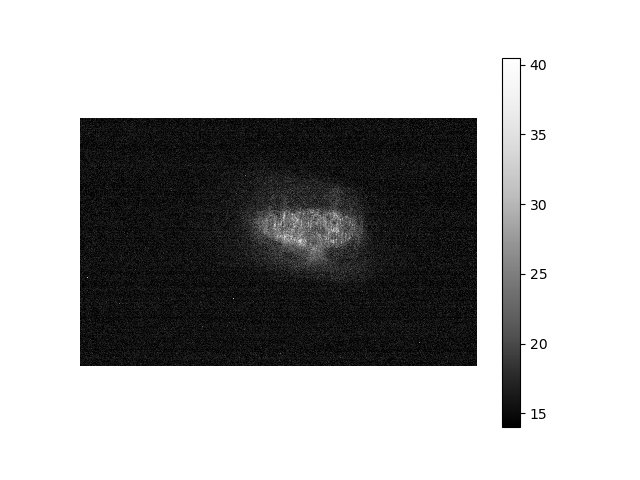
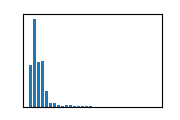

In [2]:

import numpy as np
import tifffile as tiff
import stackview

ill_0 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-0_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
ill_1 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-1_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
merged_mean = (ill_0 + ill_1) / 2
stackview.insight(merged_mean[11]) # , continuous_update=True

StackViewNDArray([[[16, 16, 16, ..., 15, 15, 16],
                   [15, 15, 16, ..., 16, 15, 16],
                   [15, 16, 17, ..., 15, 17, 16],
                   ...,
                   [16, 17, 18, ..., 17, 16, 15],
                   [15, 15, 16, ..., 15, 16, 16],
                   [17, 17, 18, ..., 16, 16, 15]],

                  [[18, 16, 17, ..., 16, 15, 15],
                   [17, 16, 16, ..., 16, 15, 16],
                   [14, 14, 14, ..., 15, 16, 16],
                   ...,
                   [14, 16, 15, ..., 16, 16, 15],
                   [17, 16, 16, ..., 14, 15, 16],
                   [15, 14, 14, ..., 16, 14, 16]],

                  [[15, 15, 15, ..., 17, 16, 16],
                   [16, 16, 17, ..., 16, 16, 14],
                   [18, 15, 15, ..., 15, 16, 17],
                   ...,
                   [14, 16, 17, ..., 15, 16, 15],
                   [15, 16, 16, ..., 18, 18, 16],
                   [14, 14, 15, ..., 15, 15, 16]],

                  ...,

                  [[15, 16, 17, ..., 17, 15, 14],
                   [15, 16, 17, ..., 17, 15, 16],
                   [15, 15, 15, ..., 16, 14, 14],
                   ...,
                   [15, 15, 16, ..., 14, 15, 15],
                   [16, 16, 15, ..., 14, 14, 15],
                   [14, 14, 15, ..., 16, 16, 15]],

                  [[15, 16, 15, ..., 16, 16, 16],
                   [15, 15, 15, ..., 16, 16, 14],
                   [18, 16, 14, ..., 17, 16, 14],
                   ...,
                   [16, 15, 15, ..., 16, 15, 16],
                   [17, 15, 15, ..., 15, 17, 17],
                   [17, 17, 17, ..., 16, 16, 16]],

                  [[16, 15, 14, ..., 14, 16, 15],
                   [16, 16, 17, ..., 15, 16, 14],
                   [16, 15, 15, ..., 16, 15, 14],
                   ...,
                   [14, 16, 16, ..., 17, 16, 15],
                   [16, 16, 15, ..., 16, 17, 16],
                   [16, 16, 15, ..., 16, 16, 15]]], dtype=uint8)
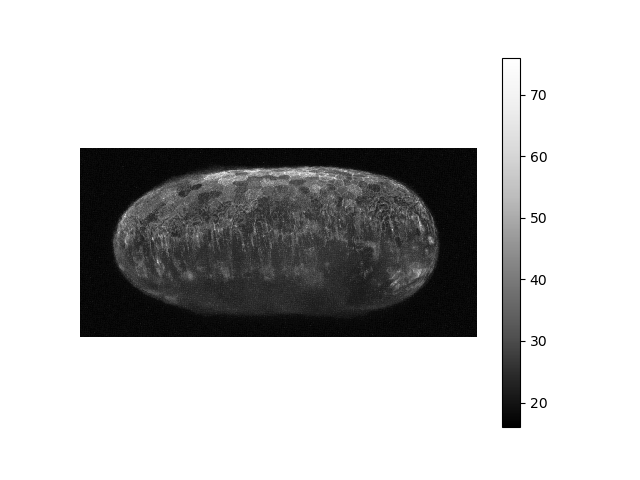
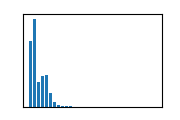

In [3]:
from peel_embryo_with_cartography import crop_around_embryo, threshold_image_xy

mask = threshold_image_xy(merged_mean)

ill_0_crop = crop_around_embryo(ill_0, mask)
ill_1_crop = crop_around_embryo(ill_1, mask, ill_0_crop.shape)

stackview.insight(ill_0_crop)

In [38]:
# Adapted from https://github.com/m-albert/MVRegFus by Marvin Albert
import dask.array as da
from scipy import ndimage

def illumination_fusion_planewise(stack, fusion_axis=2):#, sample_intensity=220):

    """

    segment sample: seg = mean(stack,0) > sample_intensity

    - divide mask into left and right
    - smooth

    good stacks for testing:

    x,y,z = np.mgrid[:100,:101,:102]
    s0 = np.abs(np.sin((y-50+z-50+x-50)/100.*np.pi)*1) * np.abs(np.sin(y/50.*np.pi)*1) * np.sin(z/100.*np.pi)*100 + 200# + np.sin(z/5.*np.pi)*5
    s1 = s0 + np.sin(z/5.*np.pi)*5

    :param stack:
    :param fusion_axis:
    :param sample_intensity:
    :return:
    """

    print('fusing illuminations planewise')

    stack = np.array(stack)

    stack = np.swapaxes(stack, fusion_axis, -1)
    stack = da.from_array(stack, chunks=(2, 1, stack.shape[-2], stack.shape[-1]))

    def fuse_planes(planes):

        planes = planes.squeeze()
        print(planes.shape)
        # mask = np.sum(stack,0)>(sample_intensity*2)
        mask = np.sum(planes, 0) - planes.min()

        mask = np.log(mask)

        mask = (mask - mask.min())/(mask.max()-mask.min())

        # pixels along fusion axis
        # total = np.sum(mask,fusion_axis-1)
        total = np.sum(mask, axis=-2)

        mask[total == 0] = True

        # total[total==0] = mask.shape[fusion_axis-1]

        total[total==0] = mask.shape[1]
        # total[total==0] = (mask.shape[fusion_axis]*(mask.shape[fusion_axis]+1))/2./2.

        # print(mask.shape)

        # pixel count from left
        # cumsum = np.cumsum(mask, fusion_axis-1)
        cumsum = np.cumsum(mask, axis=-2)


        # right_weight = cumsum > total/2.
        right_weight = (cumsum.T > total.T/2.).T
        # right_weight = (cumsum.T > np.sum(cumsum,fusion_axis).T/2.).T

        kernel = np.array(mask.shape)/100*2.
        right_weight = ndimage.gaussian_filter(right_weight.astype(np.float32),kernel)

        planes = planes[0] * (1-right_weight) + planes[1] * right_weight

        planes = planes.astype(np.uint16)[None,:,:]

        return planes

    from dask.diagnostics import ProgressBar
    with ProgressBar():
        stack = stack.map_blocks(fuse_planes, drop_axis=0, dtype=np.uint16).compute(scheduler='single-threaded')

    stack = np.swapaxes(stack, fusion_axis, -1)

    return stack


StackViewNDArray([[14. , 16. , 15. , ..., 14.5, 17. , 14.5],
                  [14. , 16.5, 14. , ..., 15.5, 16. , 15. ],
                  [16.5, 17. , 14. , ..., 14. , 15. , 15. ],
                  ...,
                  [15. , 17. , 14. , ..., 14.5, 16. , 16.5],
                  [14. , 15. , 16. , ..., 15. , 17. , 17. ],
                  [14.5, 15. , 15. , ..., 16. , 15. , 16. ]])
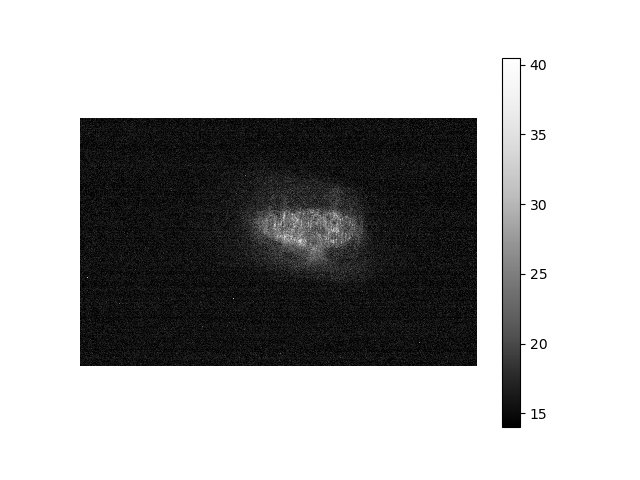
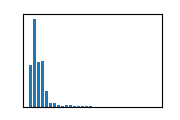

In [ ]:

import numpy as np
import tifffile as tiff
import stackview

ill_0 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-0_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
ill_1 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-1_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
merged_mean = (ill_0 + ill_1) / 2
stackview.insight(merged_mean[11]) # , continuous_update=True

StackViewNDArray([[14. , 16. , 15. , ..., 14.5, 17. , 14.5],
                  [14. , 16.5, 14. , ..., 15.5, 16. , 15. ],
                  [16.5, 17. , 14. , ..., 14. , 15. , 15. ],
                  ...,
                  [15. , 17. , 14. , ..., 14.5, 16. , 16.5],
                  [14. , 15. , 16. , ..., 15. , 17. , 17. ],
                  [14.5, 15. , 15. , ..., 16. , 15. , 16. ]])
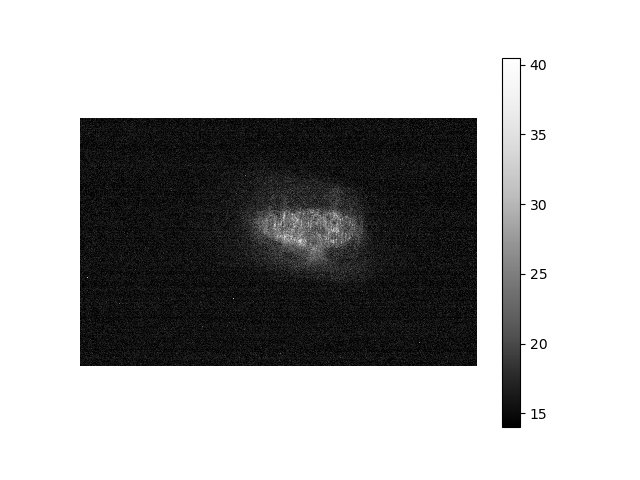
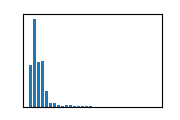

In [ ]:

import numpy as np
import tifffile as tiff
import stackview

ill_0 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-0_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
ill_1 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-1_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
merged_mean = (ill_0 + ill_1) / 2
stackview.insight(merged_mean[11]) # , continuous_update=True

StackViewNDArray([[14. , 16. , 15. , ..., 14.5, 17. , 14.5],
                  [14. , 16.5, 14. , ..., 15.5, 16. , 15. ],
                  [16.5, 17. , 14. , ..., 14. , 15. , 15. ],
                  ...,
                  [15. , 17. , 14. , ..., 14.5, 16. , 16.5],
                  [14. , 15. , 16. , ..., 15. , 17. , 17. ],
                  [14.5, 15. , 15. , ..., 16. , 15. , 16. ]])
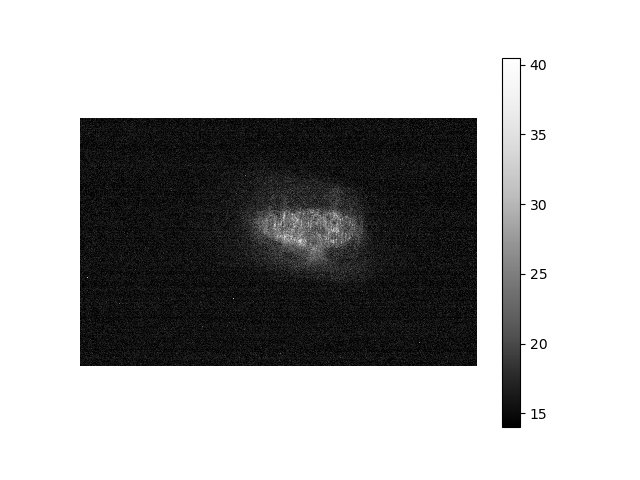
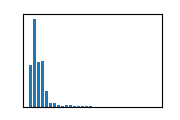

In [3]:

import numpy as np
import tifffile as tiff
import stackview

ill_0 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-0_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
ill_1 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-1_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
merged_mean = (ill_0 + ill_1) / 2
stackview.insight(merged_mean[11]) # , continuous_update=True

StackViewNDArray([[14. , 16. , 15. , ..., 14.5, 17. , 14.5],
                  [14. , 16.5, 14. , ..., 15.5, 16. , 15. ],
                  [16.5, 17. , 14. , ..., 14. , 15. , 15. ],
                  ...,
                  [15. , 17. , 14. , ..., 14.5, 16. , 16.5],
                  [14. , 15. , 16. , ..., 15. , 17. , 17. ],
                  [14.5, 15. , 15. , ..., 16. , 15. , 16. ]])
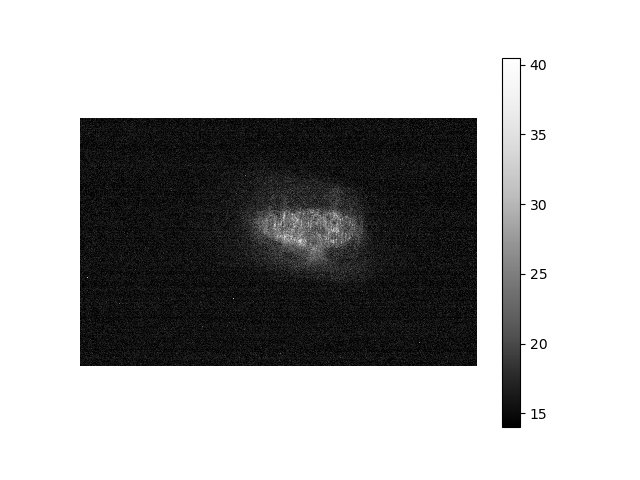
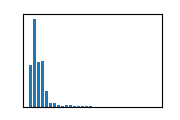

In [11]:

import numpy as np
import tifffile as tiff
import stackview

ill_0 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-0_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
ill_1 = tiff.imread('0_raw_data_merge_illum/timelapseID-20240926-211701_SPC-0002_TP-0400_ILL-1_CAM-1_CH-00_PL-(ZS)-outOf-0072.tif')
merged_mean = (ill_0 + ill_1) / 2
stackview.insight(merged_mean[11]) # , continuous_update=True

In [39]:
x,y,z = np.mgrid[:100,:101,:102]
s0 = np.abs(np.sin((y-50+z-50+x-50)/100.*np.pi)*1) * np.abs(np.sin(y/50.*np.pi)*1) * np.sin(z/100.*np.pi)*100 + 200# + np.sin(z/5.*np.pi)*5
s1 = s0 + np.sin(z/5.*np.pi)*5
print(s0.shape, s1.shape)

(100, 101, 102) (100, 101, 102)


In [40]:
np.stack([s0,s1], axis=0).shape

(2, 100, 101, 102)

In [43]:
fused = illumination_fusion_planewise(np.stack([s0,s1], axis=1))

fusing illuminations planewise
(0, 0, 0, 0)
[                                        ] | 0% Completed | 1.05 ms(100, 102, 101)
[                                        ] | 0% Completed | 106.27 ms


IndexError: boolean index did not match indexed array along dimension 0; dimension is 102 but corresponding boolean dimension is 101

In [23]:
def fuse_planes(planes):

        planes = planes.squeeze()
        print(planes.shape)
        # mask = np.sum(stack,0)>(sample_intensity*2)
        mask = np.sum(planes, 0) - planes.min()

        mask = np.log(mask)

        mask = (mask - mask.min())/(mask.max()-mask.min())

        # pixels along fusion axis
        # total = np.sum(mask,fusion_axis-1)
        total = np.sum(mask, axis=-2)

        mask[total == 0] = True

        # total[total==0] = mask.shape[fusion_axis-1]

        total[total==0] = mask.shape[1]
        # total[total==0] = (mask.shape[fusion_axis]*(mask.shape[fusion_axis]+1))/2./2.

        # print(mask.shape)

        # pixel count from left
        # cumsum = np.cumsum(mask, fusion_axis-1)
        cumsum = np.cumsum(mask, axis=-2)


        # right_weight = cumsum > total/2.
        right_weight = (cumsum.T > total.T/2.).T
        # right_weight = (cumsum.T > np.sum(cumsum,fusion_axis).T/2.).T

        kernel = np.array(mask.shape)/100*2.
        right_weight = ndimage.gaussian_filter(right_weight.astype(np.float32),kernel)

        planes = planes[0] * (1-right_weight) + planes[1] * right_weight

        planes = planes.astype(np.uint16)[None,:,:]

        return planes

In [35]:
to_blend = np.swapaxes(np.stack([ill_0_crop[11], ill_1_crop[11]]), 0, 2)
to_blend.shape

(1270, 607, 2)

In [36]:
merged_blending = fuse_planes(to_blend)
merged_blending.shape

(1270, 607, 2)


(1, 607, 2)

In [4]:
import numpy as np

def blend_volumes(volume1: np.ndarray, volume2: np.ndarray, blend_width: int = 20, blend_mode: str = "linear") -> np.ndarray:
    """
    Blend two 3D volumes along the Y axis (vertical axis) such that the top half is from volume1,
    the bottom half is from volume2, and a smooth transition occurs in the middle.

    Parameters:
    - volume1: np.ndarray, shape (Z, Y, X), first volume (e.g., top illumination)
    - volume2: np.ndarray, shape (Z, Y, X), second volume (e.g., bottom illumination)
    - blend_width: int, number of pixels along Y over which to blend the volumes smoothly
    - blend_mode: str, 'linear' or 'sigmoid', controls the blending function

    Returns:
    - blended_volume: np.ndarray, shape (Z, Y, X), smoothly combined volume
    """
    assert volume1.shape == volume2.shape, "Volumes must be the same shape"
    Z, Y, X = volume1.shape

    # Define the blend region around the middle of the Y axis
    mid_y = Y // 2
    start_blend = max(0, mid_y - blend_width // 2)
    end_blend = min(Y, mid_y + blend_width // 2)

    # Create blending weights along Y axis
    weights = np.ones((Y,))
    if blend_width > 0:
        if blend_mode == "linear":
            blend_zone = np.linspace(1, 0, end_blend - start_blend)
        elif blend_mode == "sigmoid":
            x = np.linspace(-6, 6, end_blend - start_blend)
            blend_zone = 1 / (1 + np.exp(-x))
            blend_zone = blend_zone[::-1]  # invert to match volume1 on top
        else:
            raise ValueError("Invalid blend_mode. Choose 'linear' or 'sigmoid'.")

        weights[start_blend:end_blend] = blend_zone
        weights[end_blend:] = 0

    # Broadcast to 3D weight masks
    weight_mask = weights[None, :, None]  # Shape (1, Y, 1)
    weight_mask = np.broadcast_to(weight_mask, (Z, Y, X))
    weight_mask_complement = 1.0 - weight_mask

    # Final blending
    blended_volume = volume1 * weight_mask + volume2 * weight_mask_complement
    return blended_volume


In [5]:
blended = blend_volumes(ill_0_crop, ill_1_crop, blend_width=200, blend_mode="sigmoid").astype(np.uint8)
# stackview.slice(blended, continuous_update=True)
# tiff.imwrite("outs/blended_illuminations.tiff", blended )

In [11]:
tiff.imwrite("outs/mean_merged_illuminations.tiff", ((ill_0_crop + ill_1_crop) / 2).astype(np.uint8))

In [6]:
mean_cropped = ((ill_0_crop + ill_1_crop) / 2).astype(np.uint8)

In [7]:
stackview.curtain(blended.astype(np.uint8), mean_cropped)

In [8]:
stackview.curtain(np.max(blended, axis=0), np.max(mean_cropped, axis=0))

In [6]:
import sys

# ... make changes to my_module.py ...

del sys.modules['peel_embryo_with_cartography'] 
from peel_embryo_with_cartography import crop_around_embryo, threshold_image_xy


In [4]:

mask = threshold_image_xy(merged_mean)


In [7]:
cropd =  crop_around_embryo(ill_0, mask)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mNo implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(UniTuple(float32 x 3), dtype=class(float32))
 
There are 2 candidate implementations:
[1m    - Of which 2 did not match due to:
    Overload in function 'ol_np_zeros': File: numba/np/arrayobj.py: Line 4484.
      With argument(s): '(UniTuple(float32 x 3), dtype=class(float32))':[0m
[1m     Rejected as the implementation raised a specific error:
       TypingError: Failed in nopython mode pipeline (step: nopython frontend)
     [1m[1m[1m[1mNo implementation of function Function(<built-in function empty>) found for signature:
      
      >>> empty(UniTuple(float32 x 3), dtype=class(float32))
      
     There are 2 candidate implementations:
     [1m      - Of which 2 did not match due to:
           Overload in function 'ol_np_empty': File: numba/np/arrayobj.py: Line 4406.
             With argument(s): '(UniTuple(float32 x 3), dtype=class(float32))':[0m
     [1m       Rejected as the implementation raised a specific error:
              TypingError: [1mCannot parse input types to function np.empty(UniTuple(float32 x 3), class(float32))[0m[0m
       raised from /home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/np/arrayobj.py:4425
     [0m
     [0m[1mDuring: resolving callee type: Function(<built-in function empty>)[0m
     [0m[1mDuring: typing of call at /home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/np/arrayobj.py (4489)
     [0m
     [1m
     File "../../../mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/np/arrayobj.py", line 4489:[0m
     [1m    def impl(shape, dtype=float):
     [1m        arr = np.empty(shape, dtype=dtype)
     [0m        [1m^[0m[0m
     
     [0m[1mDuring: Pass nopython_type_inference[0m[0m
  raised from /home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/core/typeinfer.py:1074
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function zeros>)[0m
[0m[1mDuring: typing of call at /home/artemiy/src/meshes_and_cartography/tubetracing_peeling_algorithm/peel_embryo_with_cartography.py (106)
[0m
[1m
File "peel_embryo_with_cartography.py", line 106:[0m
[1mdef crop_rotated_3d(image, center, size, rotation_matrix):
    <source elided>
    depth, height, width = size
[1m    out = np.zeros((depth, height, width), dtype=np.float32)
[0m    [1m^[0m[0m

[0m[1mDuring: Pass nopython_type_inference[0m

StackViewNDArray([[[16, 16, 17, ..., 15, 16, 16],
                   [15, 16, 18, ..., 15, 16, 15],
                   [16, 17, 16, ..., 17, 16, 15],
                   ...,
                   [17, 18, 17, ..., 16, 15, 15],
                   [15, 16, 17, ..., 16, 16, 16],
                   [17, 18, 16, ..., 16, 15, 15]],

                  [[16, 17, 17, ..., 15, 15, 18],
                   [16, 16, 15, ..., 15, 16, 14],
                   [14, 14, 16, ..., 16, 16, 14],
                   ...,
                   [16, 15, 16, ..., 16, 15, 16],
                   [16, 16, 16, ..., 15, 16, 16],
                   [14, 14, 15, ..., 14, 16, 15]],

                  [[15, 15, 16, ..., 16, 16, 16],
                   [16, 17, 14, ..., 16, 14, 16],
                   [15, 15, 17, ..., 16, 17, 14],
                   ...,
                   [16, 17, 16, ..., 16, 15, 15],
                   [16, 16, 14, ..., 18, 16, 15],
                   [14, 15, 15, ..., 15, 16, 16]],

                  ...,

                  [[16, 17, 14, ..., 15, 14, 15],
                   [16, 17, 16, ..., 15, 16, 14],
                   [15, 15, 15, ..., 14, 14, 15],
                   ...,
                   [15, 16, 16, ..., 15, 15, 16],
                   [16, 15, 16, ..., 14, 15, 15],
                   [14, 15, 17, ..., 16, 15, 16]],

                  [[16, 15, 16, ..., 16, 16, 15],
                   [15, 15, 14, ..., 16, 14, 14],
                   [16, 14, 16, ..., 16, 14, 16],
                   ...,
                   [15, 15, 15, ..., 15, 16, 16],
                   [15, 15, 15, ..., 17, 17, 15],
                   [17, 17, 16, ..., 16, 16, 16]],

                  [[15, 14, 15, ..., 16, 15, 15],
                   [16, 17, 14, ..., 16, 14, 14],
                   [15, 15, 14, ..., 15, 14, 17],
                   ...,
                   [16, 16, 15, ..., 16, 15, 16],
                   [16, 15, 15, ..., 17, 16, 16],
                   [16, 15, 15, ..., 16, 15, 15]]], dtype=uint8)
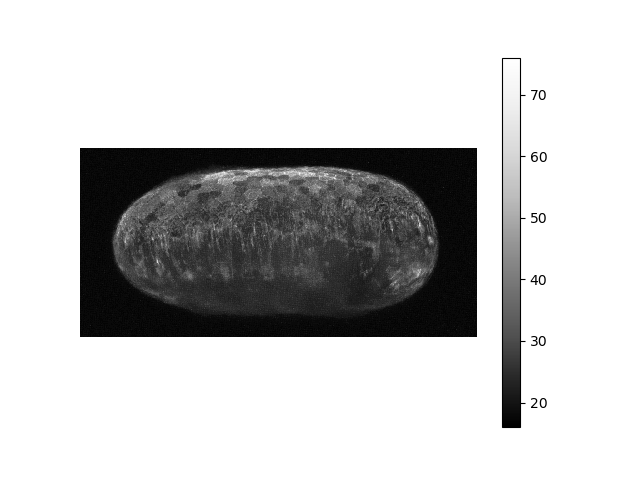
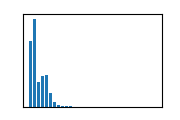

In [53]:
stackview.insight(cropd)

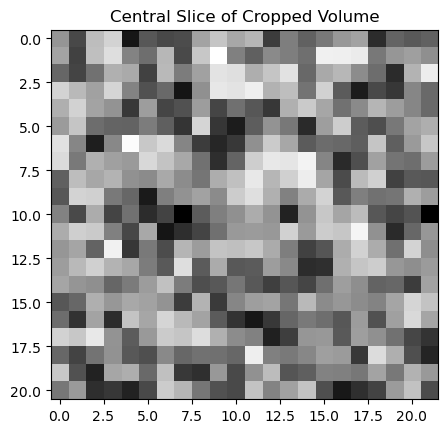

In [10]:
import numpy as np
from numba import njit, prange

# Fixed Numba-compatible version
@njit(parallel=True, fastmath=True)
def crop_rotated_3d_numba(image, center, size, inv_rot):
    depth, height, width = size
    out = np.zeros((depth, height, width), dtype=np.float32)

    for z in prange(depth):
        dz = z - depth // 2
        for y in range(height):
            dy = y - height // 2
            for x in range(width):
                dx = x - width // 2

                # Apply inverse rotation and shift to image space
                coord = np.empty(3, dtype=np.float32)
                coord[0] = dz
                coord[1] = dy
                coord[2] = dx
                src = inv_rot @ coord + center

                zf, yf, xf = src
                zi, yi, xi = int(np.floor(zf)), int(np.floor(yf)), int(np.floor(xf))
                dzf, dyf, dxf = zf - zi, yf - yi, xf - xi

                val = 0.0
                for zz in range(2):
                    for yy in range(2):
                        for xx in range(2):
                            iz = zi + zz
                            iy = yi + yy
                            ix = xi + xx
                            if 0 <= iz < image.shape[0] and 0 <= iy < image.shape[1] and 0 <= ix < image.shape[2]:
                                w = ((1 - abs(zz - dzf)) *
                                     (1 - abs(yy - dyf)) *
                                     (1 - abs(xx - dxf)))
                                val += w * image[iz, iy, ix]
                out[z, y, x] = val

    return out

# Test case
def test_crop_rotated_3d_numba():
    image = np.random.rand(50, 50, 50).astype(np.float32)
    center = np.array([25.0, 25.0, 25.0], dtype=np.float32)
    size = (20, 21, 22)
    angle = np.deg2rad(30)

    # Rotation around Z axis
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(angle), -np.sin(angle)],
        [0, np.sin(angle),  np.cos(angle)],
    ])
    inv_rot = np.linalg.inv(rotation_matrix).astype(np.float32)

    result = crop_rotated_3d_numba(image, center, size, inv_rot)
    return result

result = test_crop_rotated_3d_numba()
import matplotlib.pyplot as plt
plt.imshow(result[result.shape[0] // 2], cmap='gray')
plt.title("Central Slice of Cropped Volume")
plt.show()


In [66]:
image = np.random.rand(200, 1000, 1000).astype(np.float32)
center = np.array([100, 500.0, 500.0], dtype=np.float32)
size = (500, 500, 500)
angle = np.deg2rad(30)

# Rotation around Z axis
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle), 0],
    [np.sin(angle),  np.cos(angle), 0],
    [0,              0,             1]
], dtype=np.float32)
inv_rot = np.linalg.inv(rotation_matrix).astype(np.float32)


In [68]:

result = crop_rotated_3d_numba(image, center, size, inv_rot)

In [10]:
import torch
import torch.nn.functional as F

def crop_rotated_3d_torch(image, center, size, rotation_matrix, device='cuda'):
    """
    High-performance GPU 3D crop with rotation using PyTorch.

    :param image: 3D numpy array (Z, Y, X), float32
    :param center: (z, y, x) center of the crop region
    :param size: (depth, height, width) of the desired output
    :param rotation_matrix: 3x3 rotation matrix (numpy or torch)
    :param device: 'cuda' or 'cpu'
    :return: Cropped 3D region as numpy array (float32)
    """
    # Move everything to torch
    image_tensor = torch.from_numpy(image).to(torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (B=1, C=1, D, H, W)
    center = torch.tensor(center, dtype=torch.float32, device=device)
    rotation_matrix = torch.tensor(rotation_matrix, dtype=torch.float32, device=device)

    D, H, W = size
    dz = torch.linspace(-D/2 + 0.5, D/2 - 0.5, D, device=device)
    dy = torch.linspace(-H/2 + 0.5, H/2 - 0.5, H, device=device)
    dx = torch.linspace(-W/2 + 0.5, W/2 - 0.5, W, device=device)
    zz, yy, xx = torch.meshgrid(dz, dy, dx, indexing='ij')  # (D, H, W)

    grid = torch.stack([zz, yy, xx], dim=-1).reshape(-1, 3)  # (D*H*W, 3)

    # Apply rotation and translation
    world_coords = grid @ rotation_matrix.T + center[None, :]

    # Normalize to [-1, 1] for grid_sample
    iz, iy, ix = image_tensor.shape[-3:]
    norm_coords = torch.empty_like(world_coords)
    norm_coords[:, 0] = 2.0 * world_coords[:, 2] / (ix - 1) - 1.0  # X
    norm_coords[:, 1] = 2.0 * world_coords[:, 1] / (iy - 1) - 1.0  # Y
    norm_coords[:, 2] = 2.0 * world_coords[:, 0] / (iz - 1) - 1.0  # Z

    # Reshape for grid_sample
    norm_coords = norm_coords.reshape(D, H, W, 3).unsqueeze(0)

    # Rearrange grid axes for 3D grid_sample
    norm_coords = norm_coords.permute(0, 4, 1, 2, 3)  # (B=1, 3, D, H, W)
    norm_coords = norm_coords.permute(0, 2, 3, 4, 1)  # (B, D, H, W, 3)

    # Sample the rotated crop
    cropped = F.grid_sample(image_tensor, norm_coords, mode='bilinear', align_corners=True, padding_mode='border')

    return cropped.squeeze().cpu().numpy()

In [11]:
def test_crop_rotated_3d_torch():
    image = np.random.rand(64, 64, 64).astype(np.float32)
    center = [32.0, 32.0, 32.0]
    size = (32, 32, 32)
    angle = np.deg2rad(45)

    rot_z = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,             1]
    ], dtype=np.float32)

    crop = crop_rotated_3d_torch(image, center, size, rot_z)
    return crop
